In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#  Symmpy
from sympy import Symbol, diff, erf, sqrt, init_printing, ln, exp, diff, pi

#  For printing nice Sympy results
from IPython.display import display
init_printing()

%matplotlib inline

##  References

Stack Exchange derivation of the price of a call: 
https://quant.stackexchange.com/questions/32863/bachelier-model-call-option-pricing-formula

Academic Paper pn the relation between Black-Scholes and Bachelier
https://www.mat.univie.ac.at/~schachermayer/preprnts/prpr0121.pdf

##  Black Scholes Functions
- Black Scholes call and put prices
-  Objective functions for finding volatility
- Function for vega, the derivative of option price with respect to volatility

The Black-Scholes price of a call is given by,
$$C = \Phi(d_1) S - \Phi(d_2) K e^{-r t},$$
and the price of a put by,
$$P = \Phi(-d_2)e_{-rt} - \Phi(-d_1)S,$$
where
$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ \ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma.^2}{2}\right) t\right],$$
and
$$d_2 = d_1 - \sigma \sqrt{t}.$$

In [2]:
def call_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C, d1, d2

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

def call_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return call_price(sigma, S, K, r, t) - price

def put_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return put_price(sigma, S, K, r, t) - price

def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)

## Bachelier Model

$$
C = e^{-rt} \left(Se^{rt}-K\right)
\Phi\left( \frac{Se^{rt}-K}{ \sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}} \right) + 
e^{-rt}\sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}
\phi\left(  \frac{Se^{rt}-K}{ \sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}} \right)
$$

Let's write this in a Python function.

In [3]:
def bachelier(sigma, S, K, r, t):
    d = (S * np.exp(r*t) - K) / np.sqrt(sigma**2/(2 * r) * (np.exp(2*r*t)-1) )
   
    C = np.exp(-r * t) * (S * np.exp(r * t) - K) * norm.cdf(d) + \
        np.exp(-r * t) * np.sqrt(sigma**2/(2*r) * (np.exp(2*r*t)-1) ) * norm.pdf(d)

    return C

Now, let's look at the Bachelier and Black Scholes models over a range of stock prices fixing the other inputs as constants.

Text(0, 0.5, 'Call Price ($)')

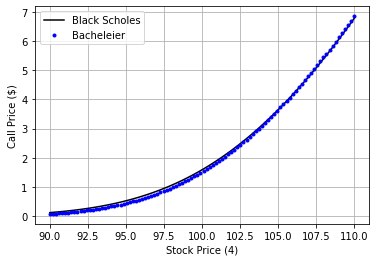

In [5]:
t = 30 / 365    #  Time to expiration
sigma = 0.30    #  Black Scholes implied volatility
K = 105         #  Strike Price
r = 0.01        #  Risk-free rate

S = np.linspace(90, 110, 100)    # Let our stock price range between $90 and $110

#  Calculate option prices based on both models
C_bs, d1, d2 = call_price(sigma, S, K, r, t)
C_ba = bachelier(sigma * S, S, K, r, t)

#  Plot the results
plt.plot(S, C_bs, 'k', label = 'Black Scholes')
plt.plot(S, C_ba, 'b.', label = 'Bacheleier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Call Price ($)')

Let's calculate $\Delta$ for the Bachelier model using a finite-difference technique to take the derivative.  Let's do this for an at-the-money call with a strike price of $105.  We'll keep the other parameters the same as above.

We'll use,
$$\frac{dr}{dx} \approx \frac{f(x + \epsilon) + f(x)}{\epsilon}$$
as our approximation for the derivative.

In [11]:
t = 30 / 365
sigma = 0.30
K = 105
r = 0.01
S = 105

#  For Black Scholes, we have a formula  for delta: Delta = norm.cds(d1)
C_bs, d1, d2 = call_price(sigma, S, K, r, t)
Delta_bs = norm.cdf(d1)
print('Delta BS = ', Delta_bs)

#  Set epsilon to a small number
epsilon = 1e-6

#  Calculate the call prices
C1_ba = bachelier(sigma * S, S, K, r, t)
C2_ba = bachelier(sigma * S, S + epsilon, K, r, t)

#  Estimate Delta
Delta_ba = (C2_ba - C1_ba) / epsilon
print('Delta BA = ', Delta_ba)

Delta BS =  0.520958769045928
Delta BA =  0.5038124020195767


Here is out Newton's method code for root finding

In [ ]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    count = 0
    epsilon = 1
    f_return = []
    fprime_return = []
    
    while epsilon >= tol:
        count += 1
        if count >= max_iter:
            print('Exiting on runaway loop.')
            return (R, count)
        
        old_R = R
        
        function_value = f(R, args = args)
        function_derivative = fprime(R, args = args)
        ind = np.where(function_derivative <= 0)
        ind = ind[0]
       
        R = -function_value / function_derivative + R
        
        if ind.size > 0:
            R[ ind ] = R[ ind ] * 0.5 + R[ ind ]
            
        if np.isscalar(R):
            epsilon = np.abs( (R - old_R) /old_R )
        else:
            epsilon = np.linalg.norm( R - old_R, np.Inf)
        
        if debug == True:
            f_return.append(function_value)
            fprime_return.append(function_derivative)
        
    return R, count, epsilon, function_value, function_derivative, f_return, fprime_return

Let's define our objective function for the Bachelier model, and calculate vega using the same differecing technique we used above.

In [8]:
def call_ba_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return bachelier(sigma, S, K, r, t) - price

def calculate_vega_ba(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    epsilon = 1e-6
    C1 = bachelier(sigma, S, K, r, t)
    C2 = bachelier(sigma + epsilon, S, K, r, t)

    return (C2 - C1) / epsilon
    

We'll see if we can reproduce the volatility used above.  In the case, the call price was $

In [9]:
C0 = 3.6445730260768543
S = 105
K = 105
r = 0.01
t = 30/365

args = (S, K, r, t, C0)

R, count, epsilon, function_value, function_derivative, f_return, fprime_return = newtons_method(call_ba_objective_function, calculate_vega_ba, 0.5, args = args)

In [10]:
print(R / S)

0.3000000000000008
